# Predicciones de contaminacion

Las Magnitudes que nos interesa predecir son las siguientes:
PM25
PM10
O3

Acorde a la matriz de correlacion las magnitudes PM25 y PM10 estan fuertemente correlacionadas por 
lo que una regrecion que considere ambas variables puede aumentar su precicion. Debido a que O3 tiene una correlacion baja con PM25 y PM10 se entrenara un modelo por su cuenta


In [26]:
import pandas as pd

df = pd.read_csv("../TimeStepData.csv")

In [27]:
# unhealthy sensors have been removed already and gaps have been filled
df.head()


,Datetime,CO_ANL1,CO_ANL10,CO_ANL11,CO_ANL12,CO_ANL13,CO_ANL2,CO_ANL3,CO_ANL4,CO_ANL5,...,VIENTOVEL_ANL11,VIENTOVEL_ANL12,VIENTOVEL_ANL13,VIENTOVEL_ANL2,VIENTOVEL_ANL3,VIENTOVEL_ANL4,VIENTOVEL_ANL5,VIENTOVEL_ANL6,VIENTOVEL_ANL8,VIENTOVEL_ANL9
0,2022-01-01 00:00:00,0.94,1.39,1.77,1.57,1.330,1.24,1.36,1.00,0.65,...,7.100000,7.500000,5.300000,9.633333,7.900000,8.966667,6.766667,11.033333,6.466667,7.233333
1,2022-01-01 01:00:00,1.05,1.50,1.36,1.57,1.600,1.35,1.53,1.13,0.70,...,7.266667,5.333333,2.900000,5.966667,6.300000,11.033333,5.533333,8.366667,3.466667,4.900000
2,2022-01-01 02:00:00,1.15,2.03,1.28,1.66,1.400,1.77,1.60,1.23,0.86,...,3.900000,5.166667,3.066667,4.533333,4.333333,7.900000,4.033333,5.333333,3.033333,2.366667
3,2022-01-01 03:00:00,1.57,2.18,1.48,1.76,2.460,2.38,2.01,1.37,1.47,...,6.200000,4.833333,3.233333,5.600000,4.200000,5.933333,3.900000,4.466667,3.700000,3.633333
4,2022-01-01 04:00:00,2.05,2.07,1.61,2.38,2.604,2.88,3.09,1.50,1.99,...,5.666667,4.933333,3.066667,6.566667,4.600000,7.900000,4.033333,3.566667,2.466667,3.333333


In [28]:
def transform(df, desired_columns, drop_sensors=[]):
    final_dataframe = df
    for column in df.columns:
        if column.split("_")[0] not in desired_columns or column.split("_")[1] in drop_sensors:
            final_dataframe = final_dataframe.drop(columns=column)

    return final_dataframe

# first we must have a dataset for our model of PM25 and PM10 predictions and our dataset for our
# O3 predictions

desired_magnitudes_pm = ["PM25", "PM10"]

pm_regressor_dataset = transform(df, desired_magnitudes_pm, ["ANL10"])
o3_regressor_dataset = transform(df, ["O3"], ["ANL10"])

In [88]:
# split data for training and testing

import numpy as np

TRAIN_PERCENTAGE = 0.995

def train_test_split(df, train_percentage: float):
    train_df = df[:int(train_percentage*len(df))]
    test_df= df[int(train_percentage*len(df)):]
    return train_df, test_df


train_pm_df, test_pm_df = train_test_split(pm_regressor_dataset, TRAIN_PERCENTAGE)
train_pm_df_logged = np.log1p(train_pm_df)

train_o3_df, test_o3_df = train_test_split(o3_regressor_dataset, TRAIN_PERCENTAGE)
train_o3_df_logged = np.log1p(train_o3_df)



In [90]:

import matplotlib.pyplot as plt

def graph_metric(data_frame: pd.DataFrame, metric_name: str):
    # number of sensors after drop
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
    axs = axs.flatten()
    
    i: int = 0
    
    for col in data_frame.columns:
        if col.split("_")[0] == metric_name:
            axs[i].plot(data_frame.index, data_frame[col])
            axs[i].set_title(col)
            i += 1

def graph_metrics(forecast_df: pd.DataFrame, true_df: pd.DataFrame, metric_name: str):
    # number of sensors after drop

    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
    axs = axs.flatten()
    
    i: int = 0
    
    for col in forecast_df.columns:
        if col.split("_")[0] == metric_name:
            axs[i].plot(forecast_df.index, forecast_df[col], label="forecast")
            axs[i].plot(true_df.index, true_df[col], label="truth")
            axs[i].set_title(col)
            i += 1



In [31]:
%matplotlib inline

22


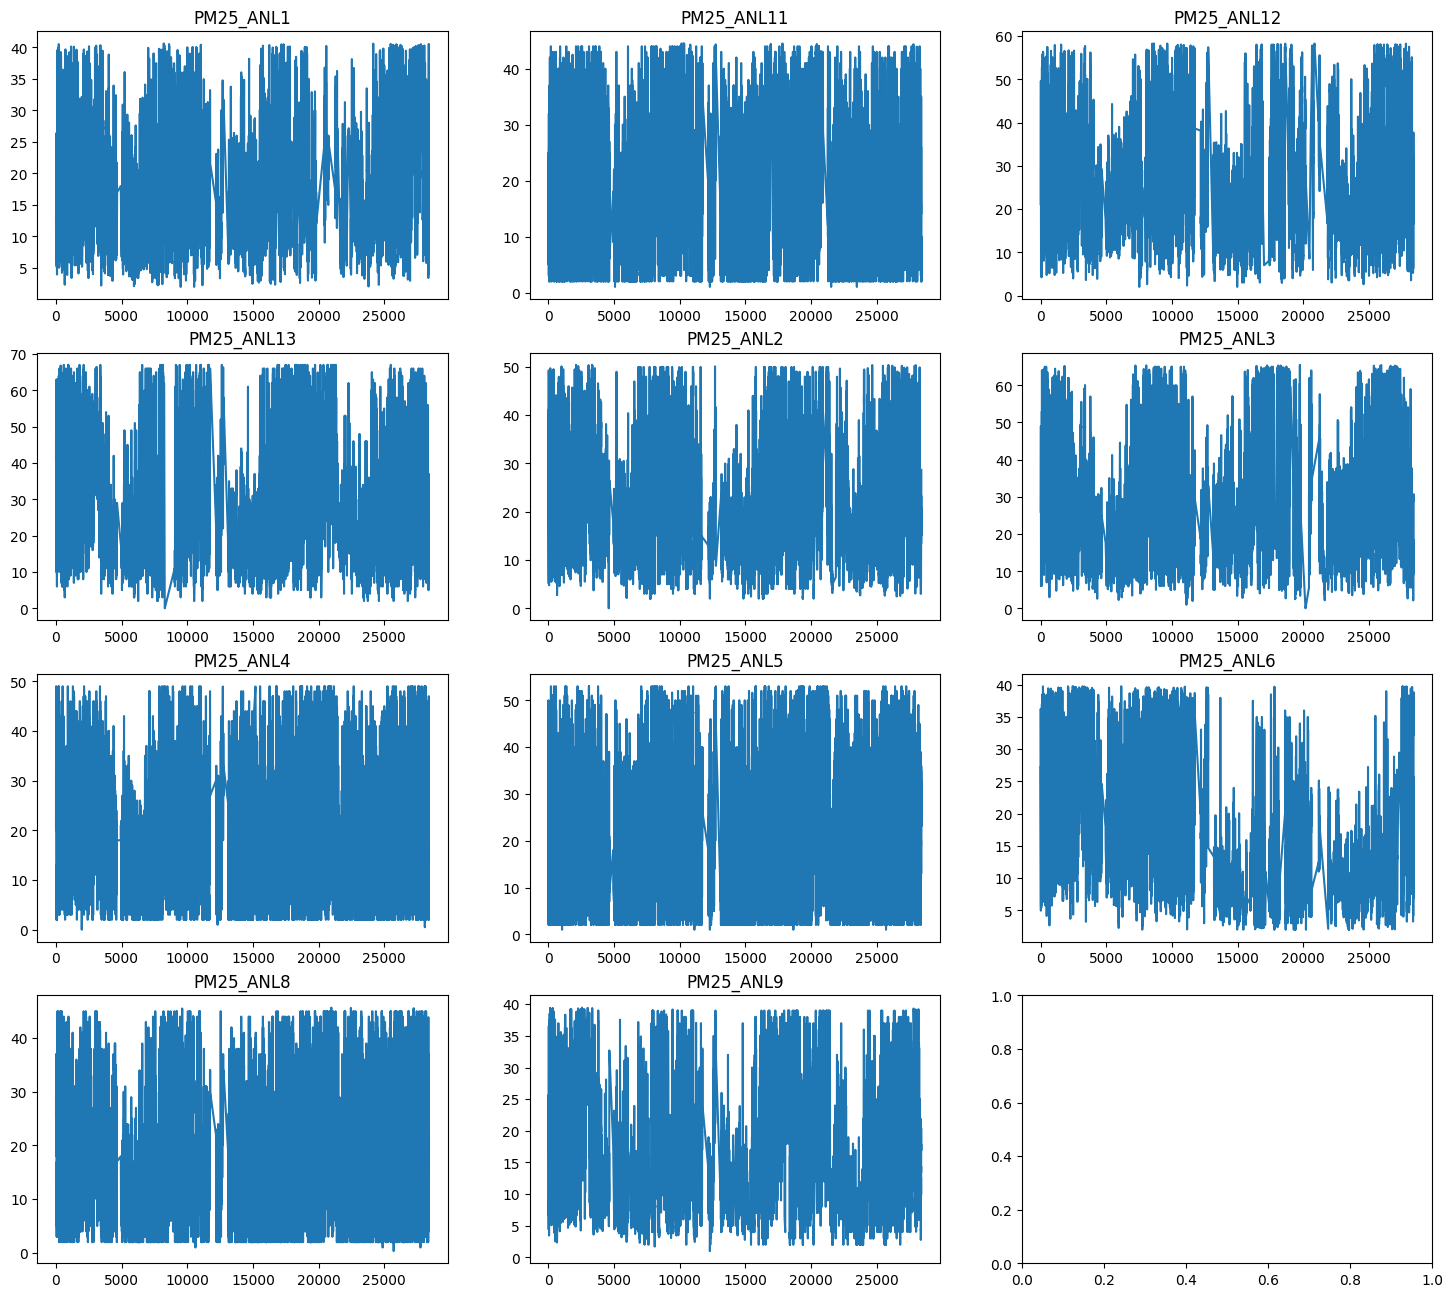

In [109]:
graph_metric(train_pm_df, "PM25")
print(len(train_pm_df.columns))

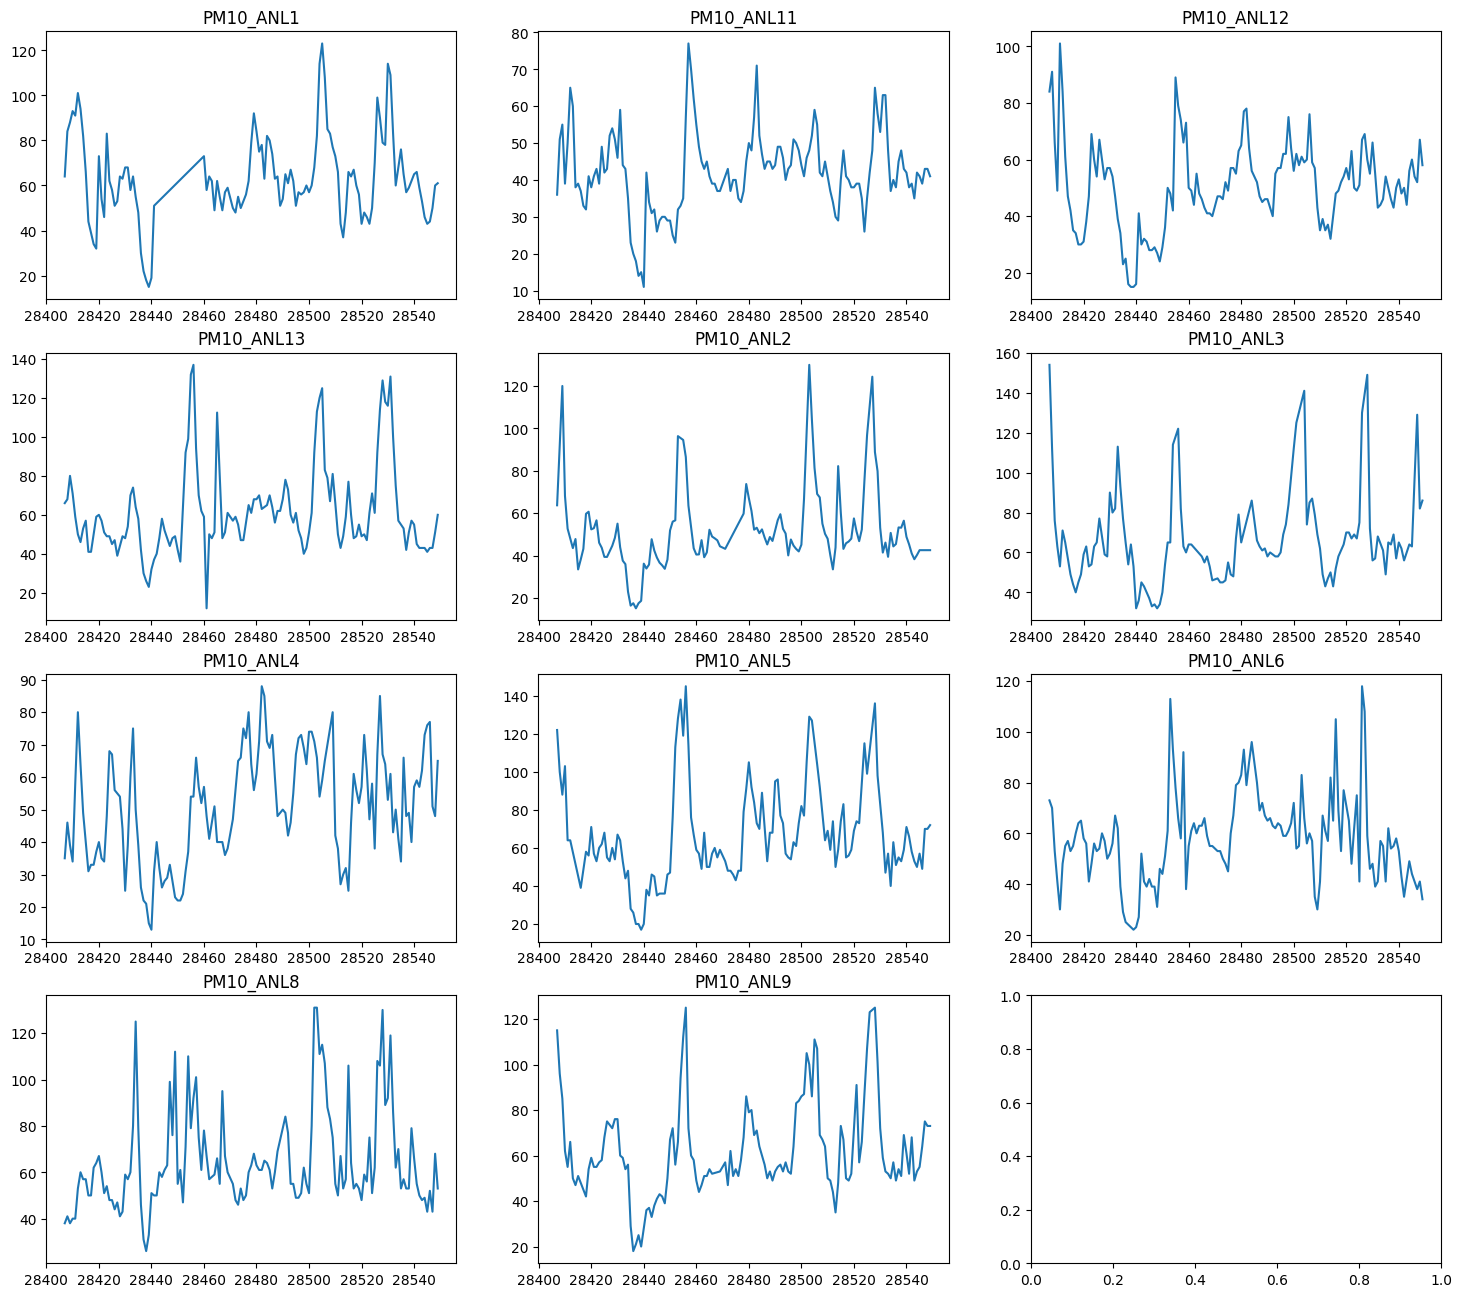

In [78]:
graph_metric(test_pm_df, "PM10")

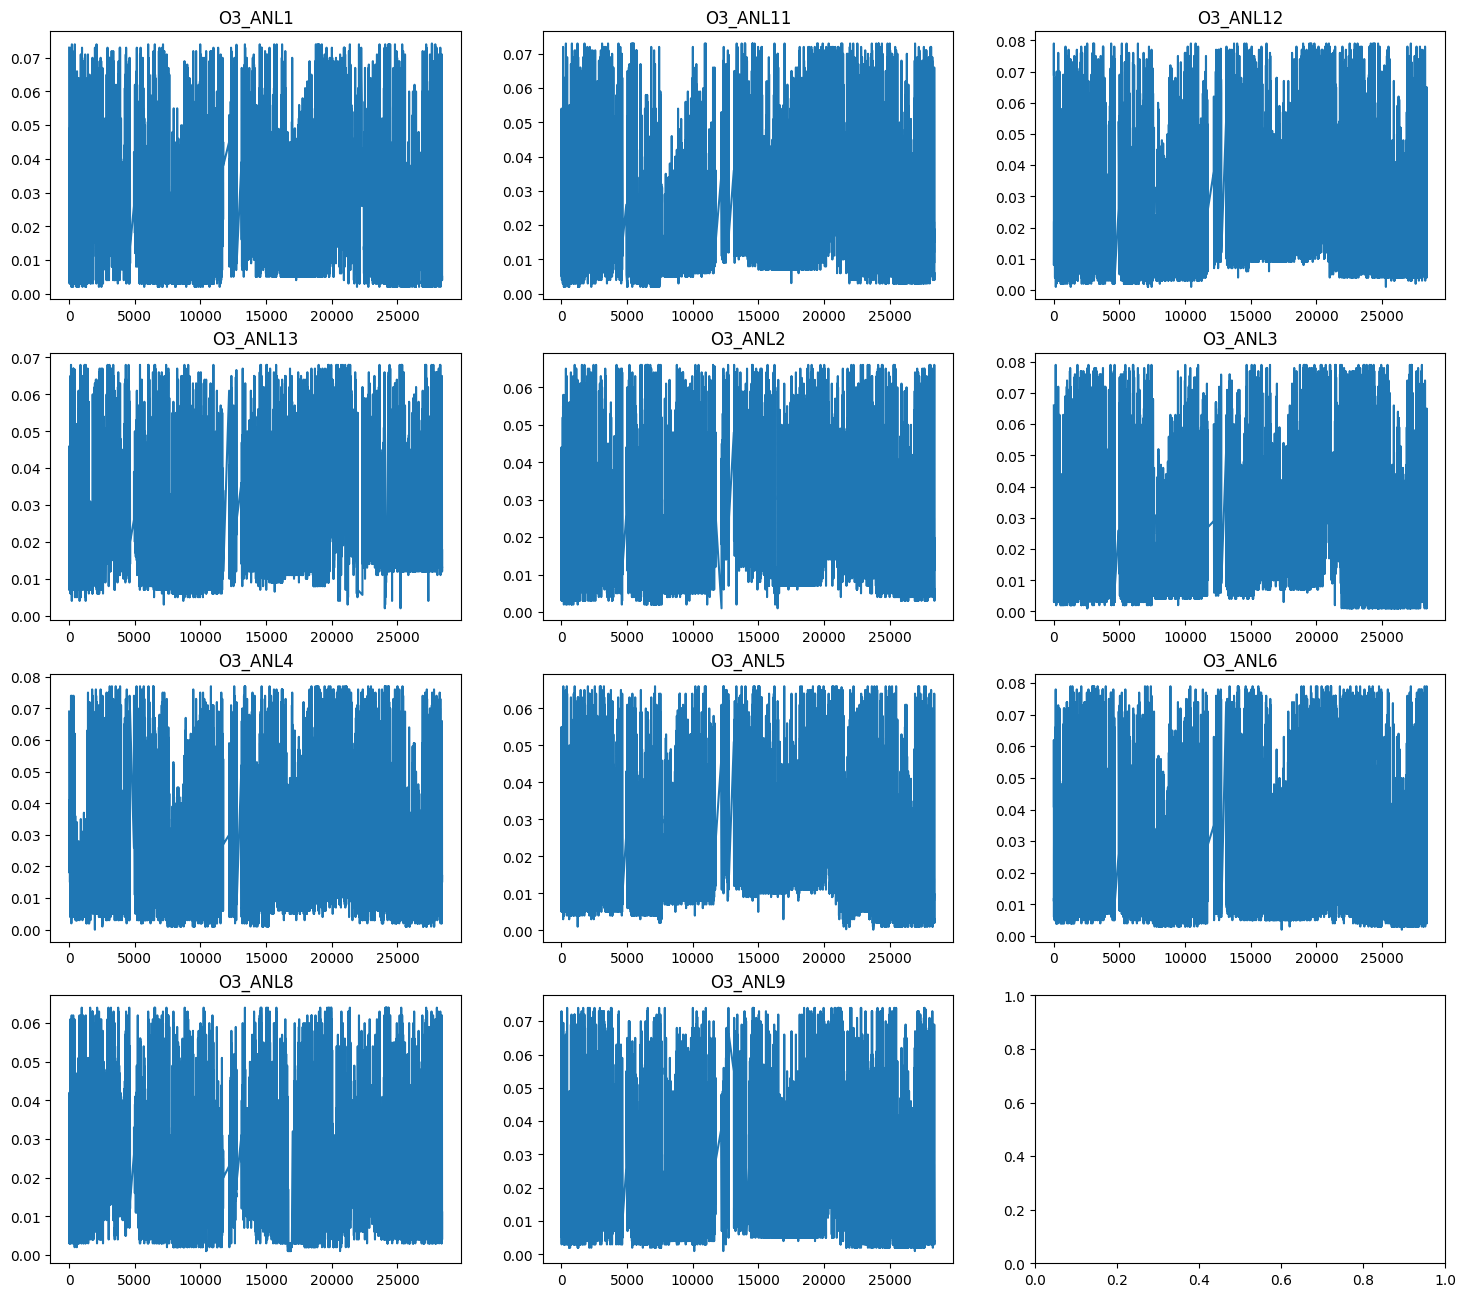

In [34]:
graph_metric(train_o3_df, "O3")

In [103]:
# train models

from statsmodels.tsa.api import VAR

pm_model = VAR(train_pm_df)
pm_results = pm_model.fit(128)

def get_forecast(nsteps: int, dataframe, regressor, results_index):
    lag_order = regressor.k_ar
    forecast_input = dataframe.values[-lag_order:]
    forecast = regressor.forecast(y=forecast_input, steps=nsteps)
    forecast_df = pd.DataFrame(forecast, columns=dataframe.columns, index=results_index)

    return forecast_df



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# --- 1. Check device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# --- 2. Dataset for multivariate time series ---
class MultiVarTimeSeriesDataset(Dataset):
    def __init__(self, df: pd.DataFrame, seq_length: int):
        self.data = df.values.astype(np.float32)  # (num_samples, num_features)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]      # shape: (seq_length, num_features)
        y = self.data[idx+self.seq_length]          # next step, shape: (num_features,)
        return torch.tensor(x), torch.tensor(y)

# --- 3. LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=180, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]    # last time step output
        out = self.linear(out)      # predict next step for all features
        return out

# --- 4. Hyperparameters ---
seq_length = 24       # 24 hours of past data
batch_size = 600
epochs = 800
learning_rate = 0.001

# --- 5. Create datasets and dataloaders ---
train_dataset = MultiVarTimeSeriesDataset(train_pm_df, seq_length)
test_dataset = MultiVarTimeSeriesDataset(test_pm_df, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = train_pm_df.shape[1]  # 22 features

# --- 6. Initialize model, loss, optimizer ---
model = LSTMModel(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# --- 7. Training ---
model.train()
for epoch in range(epochs):
    if (epoch + 1) % 100 == 0:
       torch.save(model.state_dict(), f"../models/model_epoch_{epoch+1}.pth")
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)   # (batch, seq_length, input_size)
        y_batch = y_batch.to(device)   # (batch, input_size)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x_batch.size(0)

    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

# --- 8. Evaluation on test data ---
model.eval()
preds = []
targets = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(x_batch)
        preds.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy())

preds = np.vstack(preds)    # shape: (num_test_samples, num_features)
targets = np.vstack(targets)

mse = mean_squared_error(targets, preds)
print(f"Test MSE: {mse:.6f}")

Using device: cuda
Epoch 1/800, Loss: 1979.361826
Epoch 2/800, Loss: 1291.337883
Epoch 3/800, Loss: 920.008685
Epoch 4/800, Loss: 706.023080
Epoch 5/800, Loss: 589.629768
Epoch 6/800, Loss: 530.594776
Epoch 7/800, Loss: 503.027255
Epoch 8/800, Loss: 491.166726
Epoch 9/800, Loss: 480.304611
Epoch 10/800, Loss: 363.674929
Epoch 11/800, Loss: 308.948633
Epoch 12/800, Loss: 280.814034
Epoch 13/800, Loss: 261.846257
Epoch 14/800, Loss: 248.239994
Epoch 15/800, Loss: 238.417224
Epoch 16/800, Loss: 230.939721
Epoch 17/800, Loss: 224.864217
Epoch 18/800, Loss: 219.682036
Epoch 19/800, Loss: 215.016681
Epoch 20/800, Loss: 210.783076
Epoch 21/800, Loss: 207.164474
Epoch 22/800, Loss: 203.987486
Epoch 23/800, Loss: 200.496181
Epoch 24/800, Loss: 197.680869
Epoch 25/800, Loss: 195.109493
Epoch 26/800, Loss: 192.081373
Epoch 27/800, Loss: 189.232451
Epoch 28/800, Loss: 186.570118
Epoch 29/800, Loss: 183.411648
Epoch 30/800, Loss: 180.446478
Epoch 31/800, Loss: 177.668057
Epoch 32/800, Loss: 174.920

In [104]:
forecast_df = get_forecast(len(test_pm_df), train_pm_df, pm_results, test_pm_df.index)

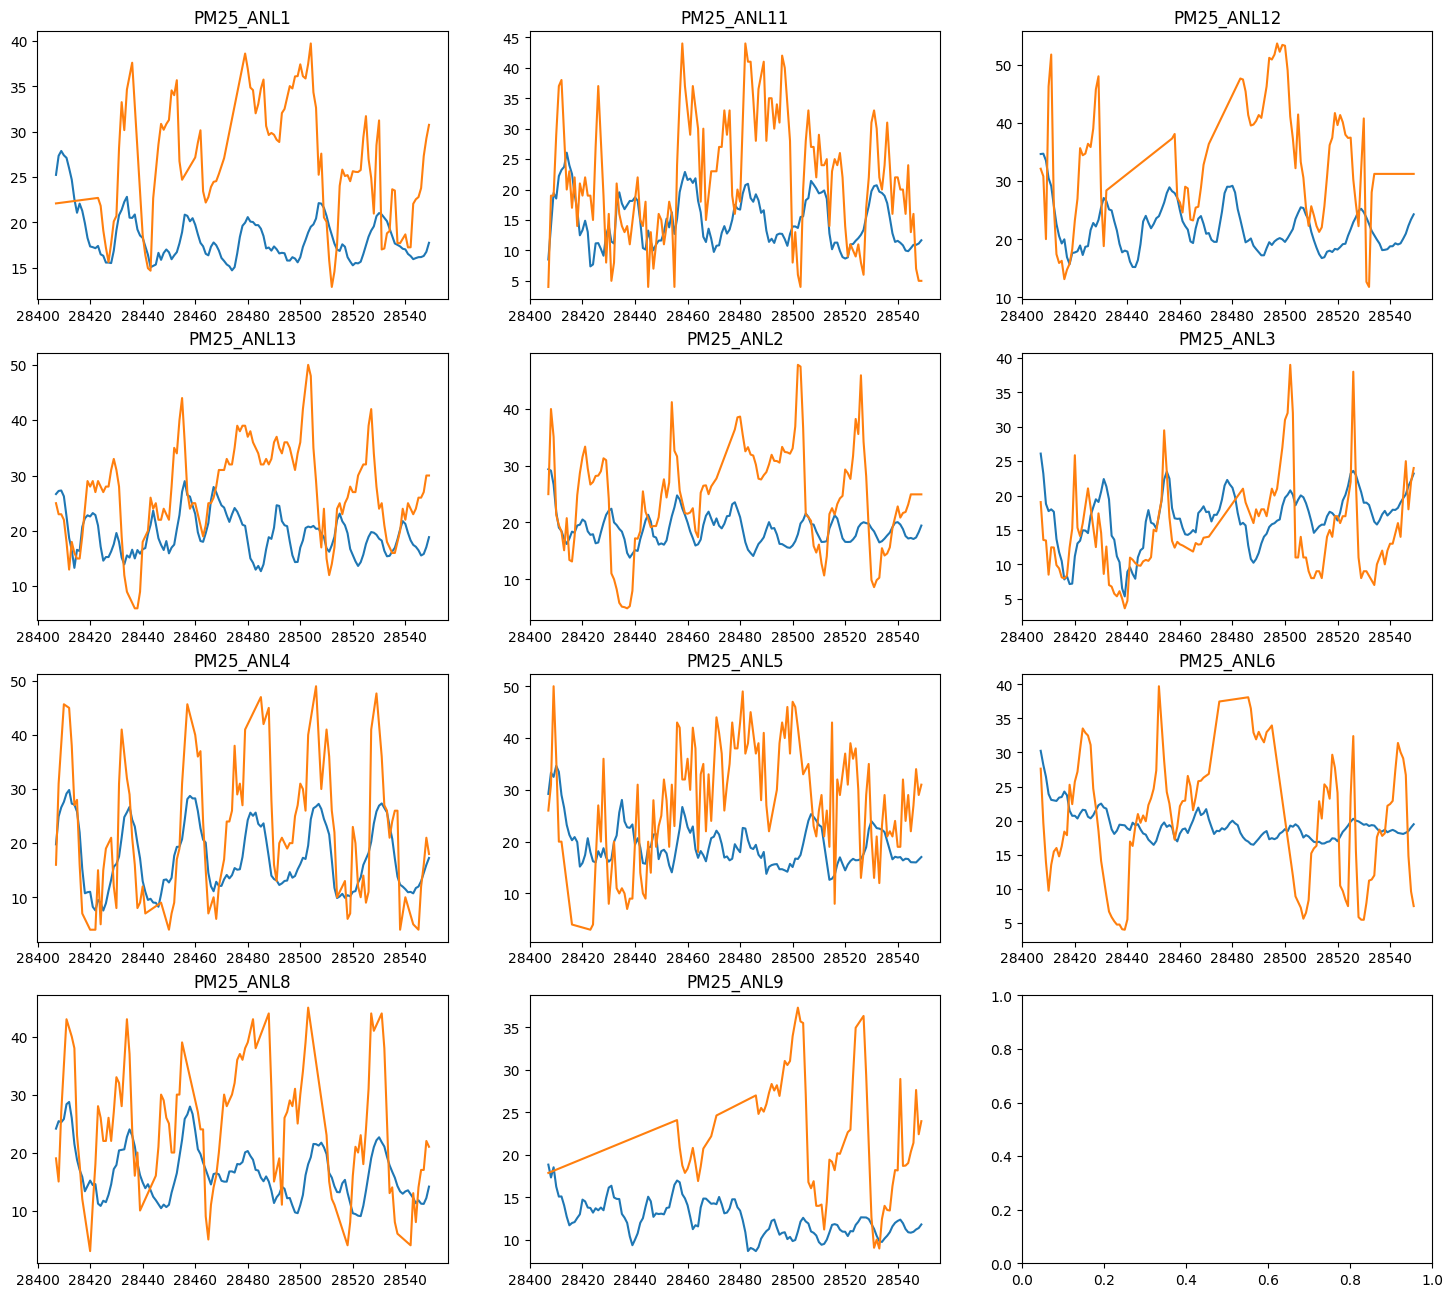

In [106]:
graph_metrics(forecast_df, test_pm_df, "PM25")

NameError: name 'df_wide' is not defined

In [ ]:
# Antes de continuar, hay que deshacernos de sensores que tienen tan pocos datos que una interpolacion
# resultaria en un resultado con un alto margen de error

discard_sensors = [
    "ANL15",
    "ANL16",
    "ANL7",
    "ANL11",
    "ANL9",
    "ANL6",
    "ANL10",
    "ANL12",
    "ANL13", 
    "ANL1",
    "ANL3",
    "ANL4"
]

columns_to_remove = [
]

for col in df_wide.columns:
    if col.split("_")[1] in discard_sensors:
        columns_to_remove.append(col)

df_wide.drop(columns=columns_to_remove, inplace=True)

In [ ]:
# antes de interpolar marcar las celdas con valores negativos como NaN para
# que sus valores verdaderos sean deducidos a traves de interpolacion

for col in df_wide.columns:
    df_wide[df_wide[col] < 0.0] = pd.NA

df_wide = df_wide.interpolate(method="time",limit_direction="both")

In [ ]:
# see if there are still any cells with nan value

In [ ]:
%matplotlib inline

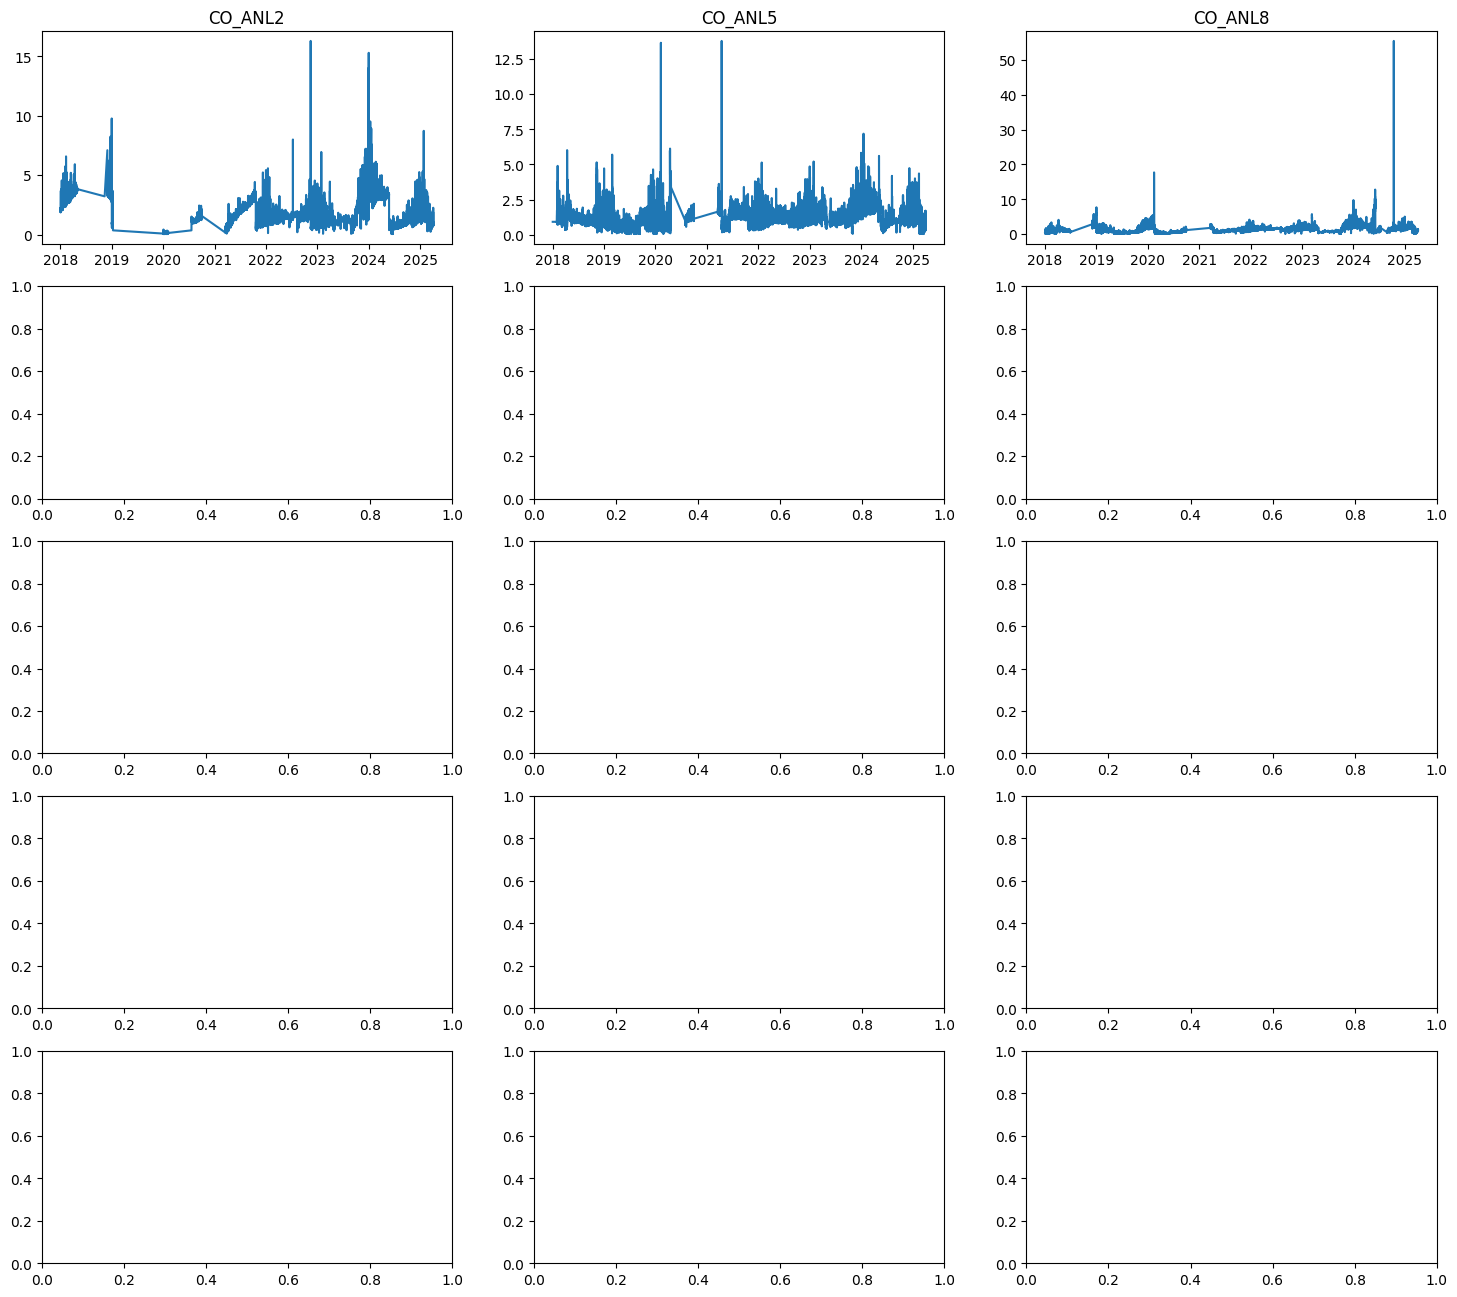

In [ ]:
# Visualizacion de datos

import matplotlib.pyplot as plt

def graph_metric(data_frame: pd.DataFrame, metric_name: str):
    # number of sensors after drop
    fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(18, 16))
    axs = axs.flatten()
    
    i: int = 0
    
    for col in data_frame.columns:
        if col.split("_")[0] == metric_name:
            axs[i].plot(data_frame.index, data_frame[col])
            axs[i].set_title(col)
            i += 1


graph_metric(df_wide, "CO")

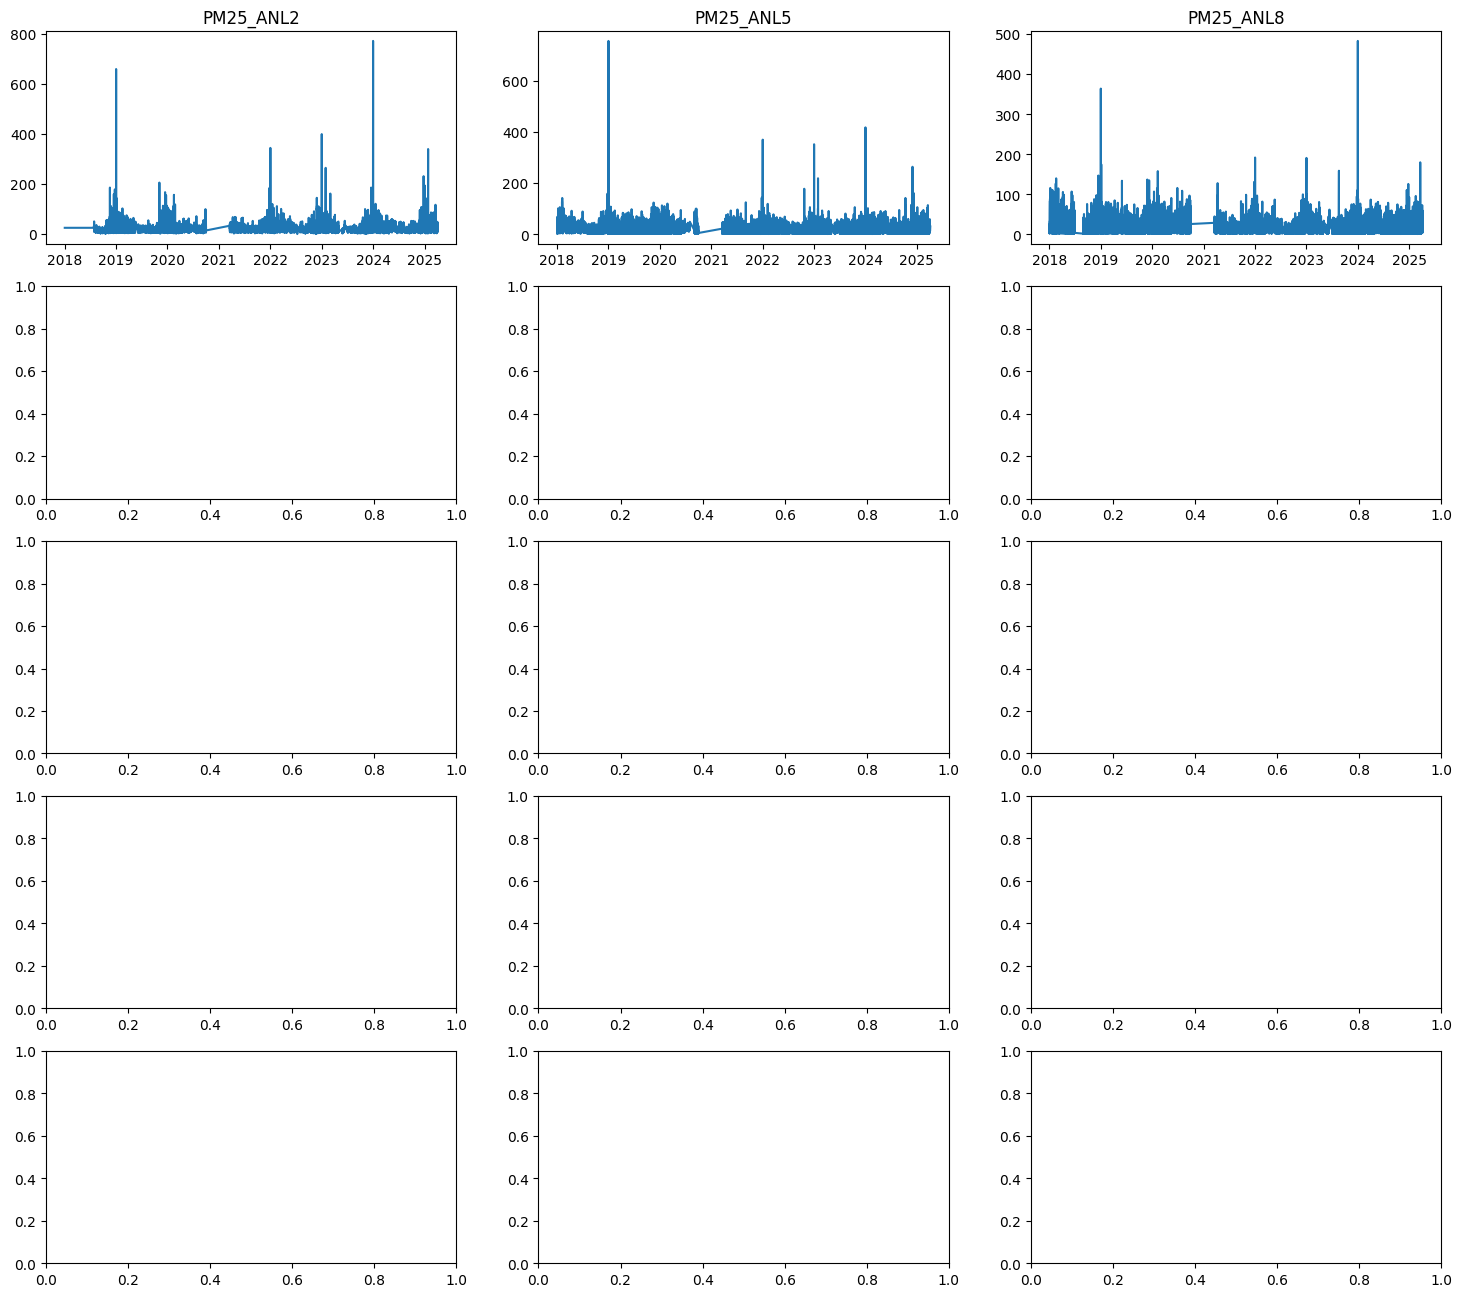

In [ ]:
graph_metric(df_wide, "PM25")

In [ ]:
df_wide.head()

,CO_ANL2,CO_ANL5,CO_ANL8,HUMEDAD_ANL2,HUMEDAD_ANL5,HUMEDAD_ANL8,LLUVIA_ANL2,LLUVIA_ANL5,LLUVIA_ANL8,NO1_ANL2,...,RS_ANL8,SO2_ANL2,SO2_ANL5,SO2_ANL8,TEMPERATURA_ANL2,TEMPERATURA_ANL5,TEMPERATURA_ANL8,VIENTOVEL_ANL2,VIENTOVEL_ANL5,VIENTOVEL_ANL8
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 08:00:00,2.20,0.92,0.32,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011700,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5
2018-01-01 09:00:00,2.17,0.92,0.31,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011500,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5
2018-01-01 10:00:00,2.14,0.92,0.29,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011300,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5
2018-01-01 11:00:00,2.10,0.92,0.26,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011300,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5
2018-01-01 12:00:00,2.05,0.92,0.24,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011233,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5


In [ ]:
# Entrenaremos un modelos de forecasting para series de tiempo llamado Vector Auto Regression

from datetime import datetime, date
from statsmodels.tsa.api import VAR, VARMAX

TRAIN_PERCENTAGE = 0.997
df_wide = df_wide[df_wide.index.year >= 2022]

train_df = df_wide[:int(len(df_wide)*TRAIN_PERCENTAGE)]
test_df = df_wide[int(len(df_wide)*TRAIN_PERCENTAGE):]

model = VAR(train_df)
results = model.fit(34) # take into conisderation 30 past values

In [ ]:
lag_order = results.k_ar
forecast_input = train_df.values[-lag_order:]

forecast = results.forecast(y=forecast_input, steps=len(test_df))  # next measurements
forecast_df = pd.DataFrame(forecast, columns=df_wide.columns, index=test_df.index)

def get_forecast(nsteps: int, dataframe, regressor):
    lag_order = regressor.k

In [ ]:
len(test_df)

86

86


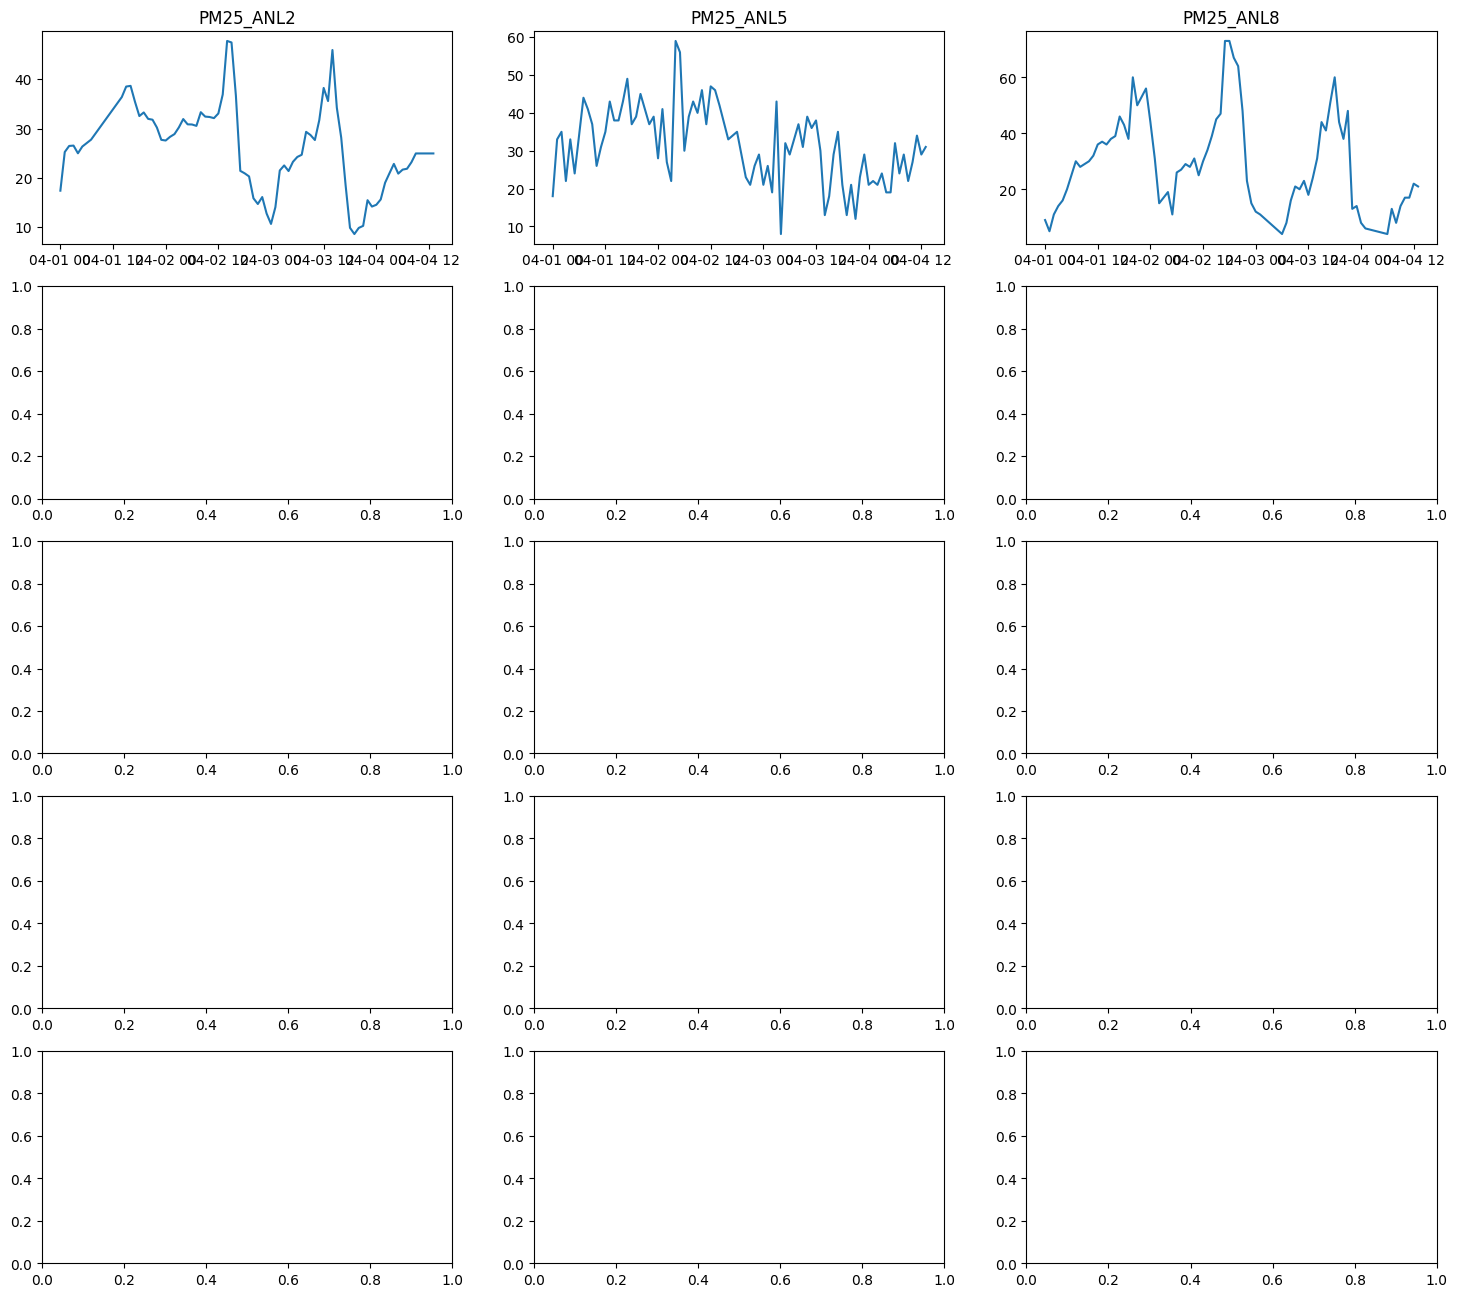

In [ ]:
# revisamos los datos en test-df

print(len(test_df))   

graph_metric(test_df, "PM25")

In [ ]:
lag_order = results.k_ar
forecast_input = train_df.values[-lag_order:]

forecast = results.forecast(y=forecast_input, steps=len(test_df))  # next measurements
forecast_df = pd.DataFrame(forecast, columns=df_wide.columns, index=test_df.index)


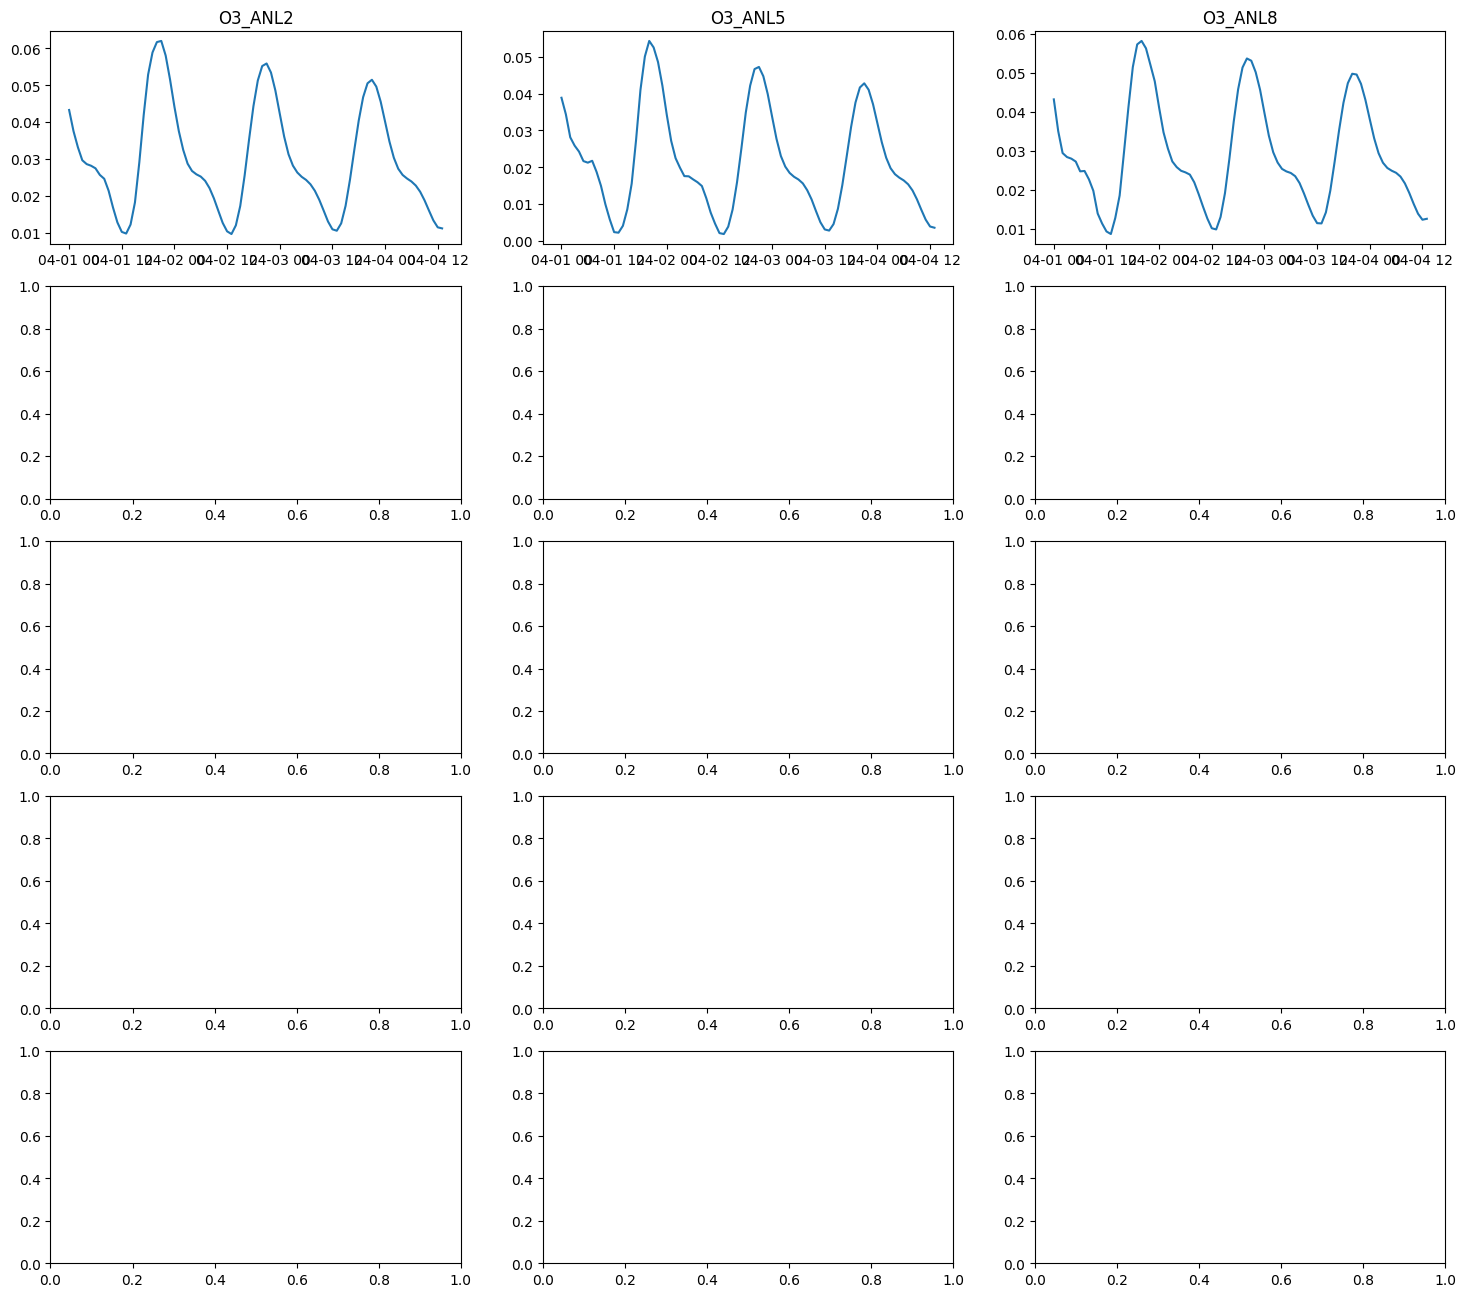

In [ ]:
graph_metric(forecast_df, "O3")

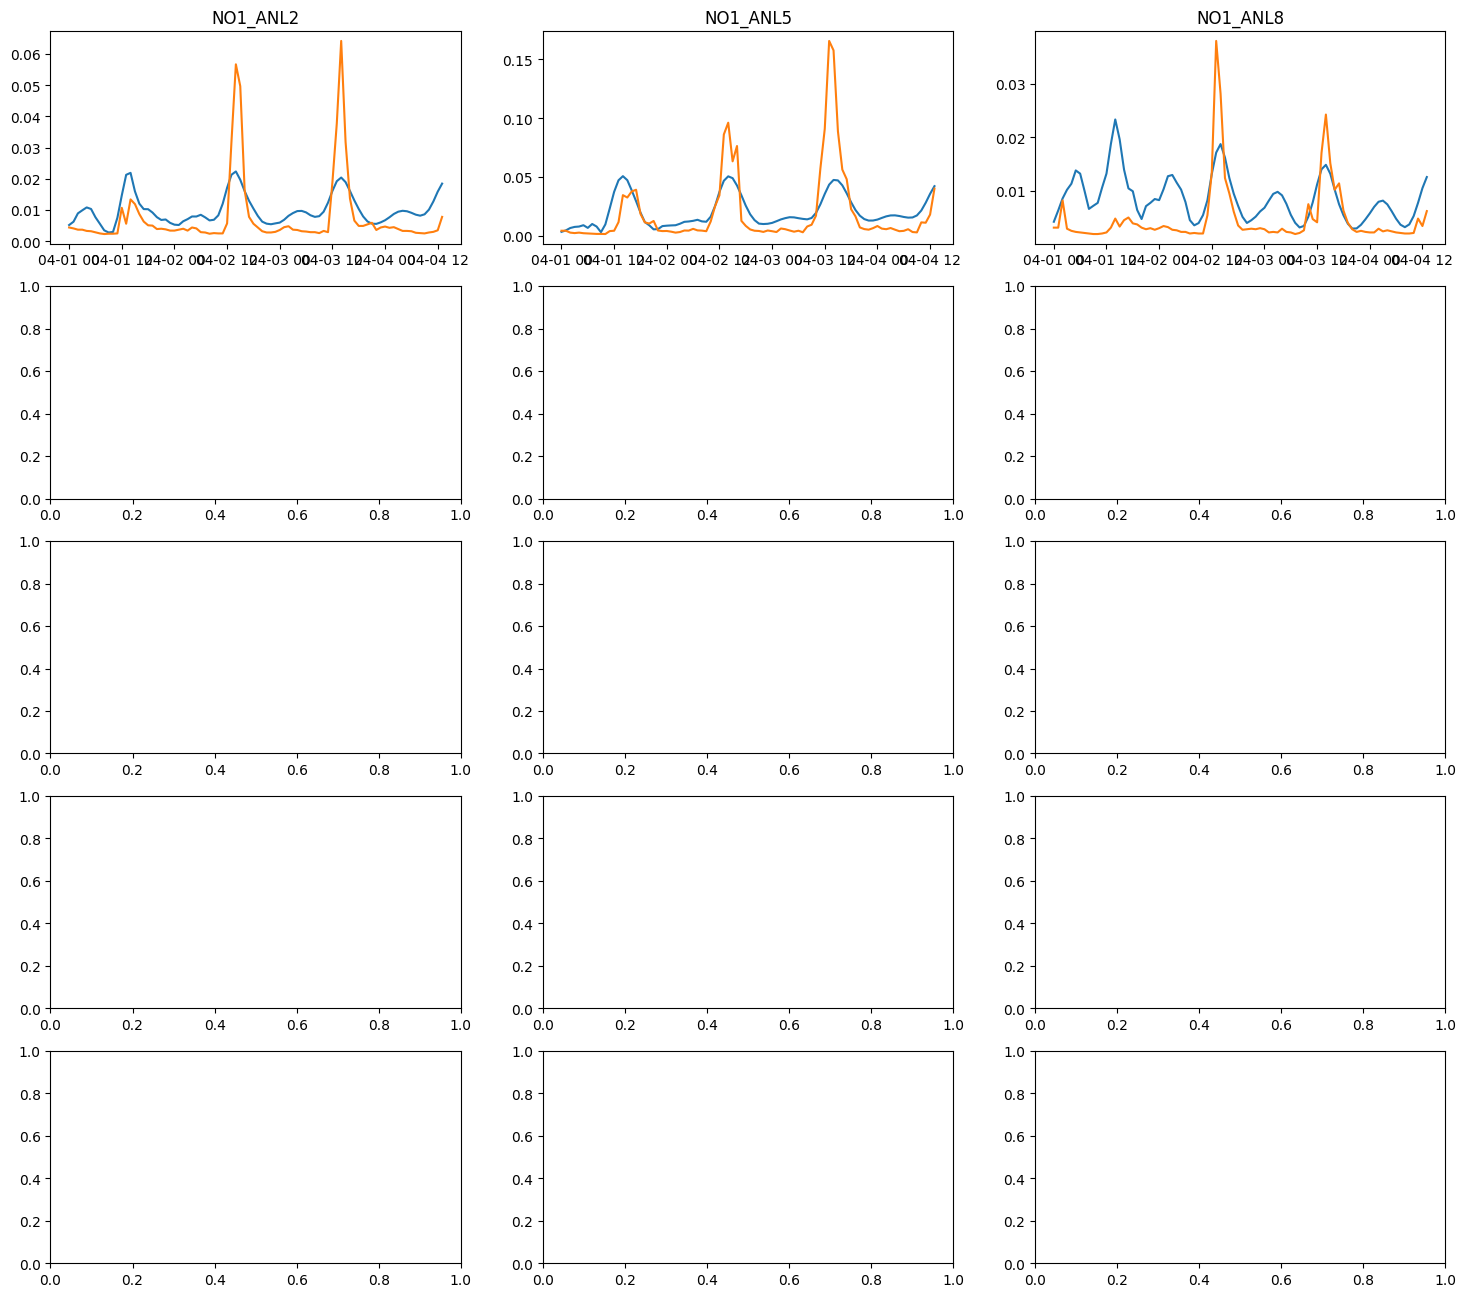

In [ ]:
from typing import List

def graph_metrics(forecast_df: pd.DataFrame, true_df: pd.DataFrame, metric_name: str):
    # number of sensors after drop

    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
    axs = axs.flatten()
    
    i: int = 0
    
    for col in forecast_df.columns:
        if col.split("_")[0] == metric_name:
            axs[i].plot(forecast_df.index, forecast_df[col], label="forecast")
            axs[i].plot(true_df.index, true_df[col], label="truth")
            axs[i].set_title(col)
            i += 1

graph_metrics(forecast_df, test_df, "NO1")


In [ ]:
df_wide.to_csv("../data/processed/Cleaned_Data.csv", index=True)